# Bollinger Bands Parameter Analysis (v2)

This notebook analyzes your Bollinger Bands parameter sweep using the new self-documenting trace format.

## 1. Setup and Import Libraries

In [2]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 2. Load Strategy Index

In [3]:
# Path to results
results_path = Path('../results/latest')

# Load the strategy index - this has all our metadata!
strategy_index = pd.read_parquet(results_path / 'strategy_index.parquet')

print(f"Total strategies tested: {len(strategy_index)}")
print("\nColumns available:")
print(strategy_index.columns.tolist())
print("\nFirst few strategies:")
strategy_index.head()

Total strategies tested: 1640

Columns available:
['strategy_id', 'strategy_hash', 'strategy_type', 'symbol', 'timeframe', 'param_period', 'param_std_dev', 'param_fast_period', 'param_slow_period', 'param_multiplier', 'full_config', 'constraints', 'trace_path']

First few strategies:


,strategy_id,strategy_hash,strategy_type,symbol,timeframe,param_period,param_std_dev,param_fast_period,param_slow_period,param_multiplier,full_config,constraints,trace_path
0,SPY_5m_compiled_strategy_0,d738d0a9b9b1,bollinger_bands,SPY_5m,1m,10,0.5,None,None,None,"{""type"": ""bollinger_bands"", ""parameters"": {""_s...",None,traces/signals/bollinger_bands/SPY_5m_compiled...
1,SPY_5m_compiled_strategy_1,961e7fad2464,bollinger_bands,SPY_5m,1m,10,0.5,None,None,None,"{""type"": ""bollinger_bands"", ""parameters"": {""_s...",None,traces/signals/bollinger_bands/SPY_5m_compiled...
2,SPY_5m_compiled_strategy_2,ab6c69ab44e5,bollinger_bands,SPY_5m,1m,10,0.5,None,None,None,"{""type"": ""bollinger_bands"", ""parameters"": {""_s...",None,traces/signals/bollinger_bands/SPY_5m_compiled...
3,SPY_5m_compiled_strategy_3,6dbebba06515,bollinger_bands,SPY_5m,1m,10,0.5,None,None,None,"{""type"": ""bollinger_bands"", ""parameters"": {""_s...",None,traces/signals/bollinger_bands/SPY_5m_compiled...
4,SPY_5m_compiled_strategy_4,b04d6977fc78,bollinger_bands,SPY_5m,1m,10,0.5,None,None,None,"{""type"": ""bollinger_bands"", ""parameters"": {""_s...",None,traces/signals/bollinger_bands/SPY_5m_compiled...


## 3. Connect to DuckDB and Query Traces

In [8]:
# Connect to DuckDB
con = duckdb.connect()

# Query signal statistics directly from traces - FIXED VERSION
signal_stats = con.execute(f"""
    WITH trace_data AS (
        SELECT 
            strategy_hash,
            json_extract_string(metadata, '$.parameters.period') as period,
            json_extract_string(metadata, '$.parameters.std_dev') as std_dev,
            COUNT(*) as num_signals,
            COUNT(DISTINCT DATE(ts)) as trading_days,
            MIN(ts) as first_signal,
            MAX(ts) as last_signal
        FROM read_parquet('{results_path}/traces/SPY_5m_1m/signals/bollinger_bands/*.parquet')
        WHERE val != 0  -- Only count actual signals
          AND metadata IS NOT NULL  -- Only use rows with metadata
        GROUP BY strategy_hash, period, std_dev
    )
    SELECT 
        strategy_hash,
        CAST(period AS INT) as period,
        CAST(std_dev AS FLOAT) as std_dev,
        num_signals,
        trading_days,
        num_signals::FLOAT / trading_days as signals_per_day,
        first_signal,
        last_signal
    FROM trace_data
    WHERE period IS NOT NULL  -- Filter out any failed extractions
    ORDER BY period, std_dev
""").df()

print(f"Loaded signal statistics for {len(signal_stats)} strategies")
signal_stats.head()

Loaded signal statistics for 70 strategies


,strategy_hash,period,std_dev,num_signals,trading_days,signals_per_day,first_signal,last_signal
0,d738d0a9b9b1,10,0.5,1,1,1.0,2024-03-26T14:40:00+00:00,2024-03-26T14:40:00+00:00
1,b8e99e6c0b74,11,0.5,1,1,1.0,2024-03-26T14:45:00+00:00,2024-03-26T14:45:00+00:00
2,ef64abfd4aa3,11,1.0,1,1,1.0,2024-03-26T14:45:00+00:00,2024-03-26T14:45:00+00:00
3,eb15e1cbeb3f,11,1.5,1,1,1.0,2024-03-26T14:45:00+00:00,2024-03-26T14:45:00+00:00
4,edd5a9f5dc00,13,0.5,1,1,1.0,2024-03-26T14:55:00+00:00,2024-03-26T14:55:00+00:00


## 4. Create Parameter Heatmaps


Strategies with optimal signal frequency (1-3 per day): 70

Top 10 by signal frequency balance:
   period  std_dev  signals_per_day  num_signals
0      10      0.5              1.0            1
1      11      0.5              1.0            1
2      11      1.0              1.0            1
3      11      1.5              1.0            1
4      13      0.5              1.0            1
5      23      0.5              1.0            1
6      24      0.5              1.0            1
7      24      1.0              1.0            1
8      25      0.5              1.0            1
9      25      1.0              1.0            1


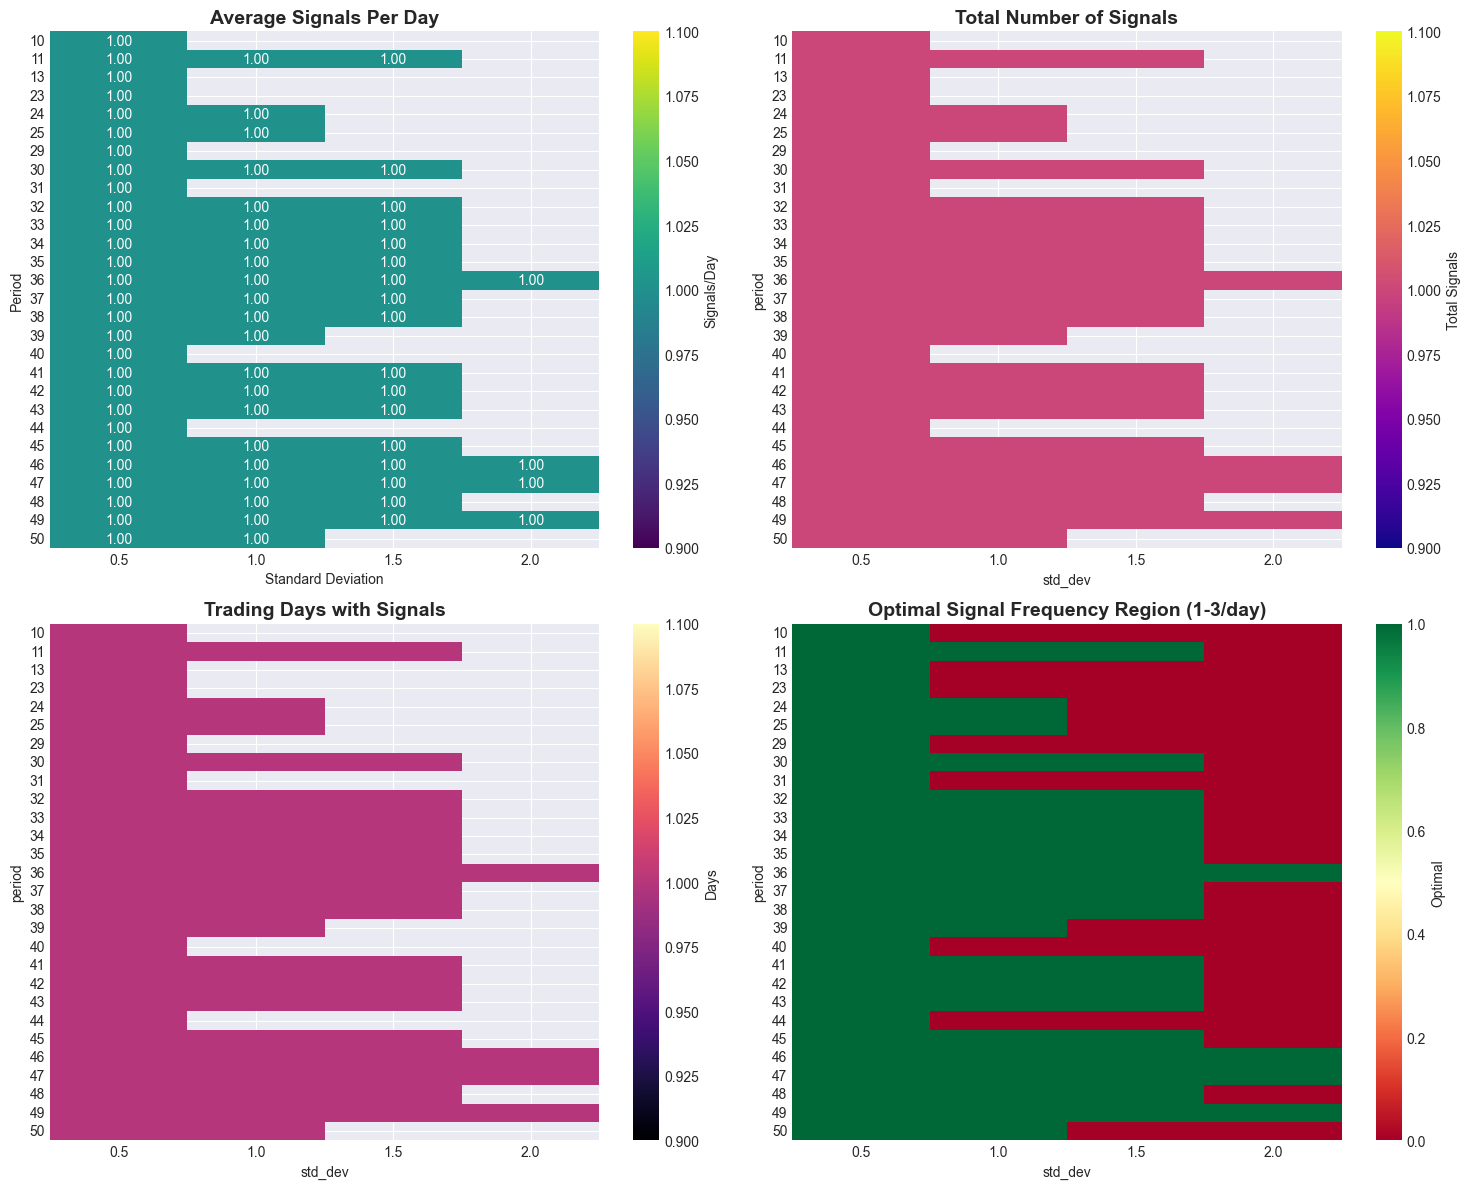

In [9]:
# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Heatmap 1: Signals per day
signals_pivot = signal_stats.pivot(index='period', columns='std_dev', values='signals_per_day')
sns.heatmap(signals_pivot, annot=True, fmt='.2f', cmap='viridis', ax=axes[0, 0], cbar_kws={'label': 'Signals/Day'})
axes[0, 0].set_title('Average Signals Per Day', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Standard Deviation')
axes[0, 0].set_ylabel('Period')

# Heatmap 2: Total number of signals
total_signals_pivot = signal_stats.pivot(index='period', columns='std_dev', values='num_signals')
sns.heatmap(total_signals_pivot, annot=False, cmap='plasma', ax=axes[0, 1], cbar_kws={'label': 'Total Signals'})
axes[0, 1].set_title('Total Number of Signals', fontsize=14, fontweight='bold')

# Find optimal signal frequency (1-3 signals per day)
optimal_freq = signal_stats[(signal_stats['signals_per_day'] >= 1) & 
                           (signal_stats['signals_per_day'] <= 3)]
print(f"\nStrategies with optimal signal frequency (1-3 per day): {len(optimal_freq)}")
print("\nTop 10 by signal frequency balance:")
print(optimal_freq.nsmallest(10, 'signals_per_day')[['period', 'std_dev', 'signals_per_day', 'num_signals']])

# Heatmap 3: Trading days active
days_pivot = signal_stats.pivot(index='period', columns='std_dev', values='trading_days')
sns.heatmap(days_pivot, annot=False, cmap='magma', ax=axes[1, 0], cbar_kws={'label': 'Days'})
axes[1, 0].set_title('Trading Days with Signals', fontsize=14, fontweight='bold')

# Heatmap 4: Optimal frequency mask
optimal_mask = (signals_pivot >= 1) & (signals_pivot <= 3)
sns.heatmap(optimal_mask.astype(int), annot=False, cmap='RdYlGn', ax=axes[1, 1], 
            cbar_kws={'label': 'Optimal'}, vmin=0, vmax=1)
axes[1, 1].set_title('Optimal Signal Frequency Region (1-3/day)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 5. Performance Analysis

If performance metrics are available in the strategy index:

# Let's see the full distribution of signals
print("Distribution of total signals:")
print(signal_stats['num_signals'].value_counts().sort_index().head(20))

print("\nLet's look at ALL strategies, not just optimal frequency:")
print(signal_stats.sort_values('num_signals', ascending=False).head(10))

# Check a specific tight parameter combination
tight_params = signal_stats[(signal_stats['period'] == 10) & (signal_stats['std_dev'] == 0.5)]
print(f"\nPeriod=10, Std=0.5 details:")
print(tight_params)

# Let's also check the actual signal data for one of these
sample_hash = signal_stats.iloc[0]['strategy_hash']
print(f"\nChecking actual signals for strategy {sample_hash}:")
sample_signals = con.execute(f"""
    SELECT ts, val, px
    FROM read_parquet('{results_path}/traces/SPY_5m_1m/signals/bollinger_bands/*.parquet')
    WHERE strategy_hash = '{sample_hash}'
    AND val != 0
    LIMIT 10
""").df()
print(sample_signals)

In [ ]:
# Check if we have performance metrics
perf_cols = [col for col in strategy_index.columns if 'sharpe' in col or 'return' in col or 'drawdown' in col]

if perf_cols:
    print(f"Found performance metrics: {perf_cols}")
    
    # Merge with signal stats
    perf_data = strategy_index[['strategy_hash'] + perf_cols].merge(
        signal_stats, on='strategy_hash', how='inner'
    )
    
    # Find best performers
    if 'sharpe_ratio' in perf_cols:
        best_sharpe = perf_data.nlargest(10, 'sharpe_ratio')
        print("\nTop 10 strategies by Sharpe Ratio:")
        print(best_sharpe[['period', 'std_dev', 'sharpe_ratio', 'signals_per_day']])
        
        # Create Sharpe heatmap
        sharpe_pivot = perf_data.pivot(index='period', columns='std_dev', values='sharpe_ratio')
        plt.figure(figsize=(10, 8))
        sns.heatmap(sharpe_pivot, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
                   cbar_kws={'label': 'Sharpe Ratio'})
        plt.title('Sharpe Ratio by Parameters', fontsize=14, fontweight='bold')
        plt.show()
else:
    print("No performance metrics found in strategy index - calculating from traces...")

## 6. Calculate Performance from Traces

In [ ]:
# Load market data
market_data_path = Path('../../../../data/SPY_5m.parquet')
market_data = pd.read_parquet(market_data_path)
print(f"Market data shape: {market_data.shape}")

# Function to calculate performance for a strategy
def calculate_strategy_performance(strategy_hash, signal_stats_row):
    # Load signals for this strategy
    signals = con.execute(f"""
        SELECT idx, ts, sym, val as signal, px
        FROM read_parquet('{results_path}/traces/*.parquet')
        WHERE strategy_hash = '{strategy_hash}'
        ORDER BY idx
    """).df()
    
    if len(signals) == 0:
        return None
    
    # Convert to proper datetime
    signals['ts'] = pd.to_datetime(signals['ts'])
    market_data['timestamp'] = pd.to_datetime(market_data['timestamp'])
    
    # Merge with market data
    df = market_data.merge(
        signals[['ts', 'signal']], 
        left_on='timestamp', 
        right_on='ts', 
        how='left'
    )
    
    # Forward fill signals (sparse to dense)
    df['signal'] = df['signal'].fillna(method='ffill').fillna(0)
    
    # Calculate returns
    df['returns'] = df['close'].pct_change()
    df['strategy_returns'] = df['returns'] * df['signal'].shift(1)
    df['cum_returns'] = (1 + df['strategy_returns']).cumprod()
    
    # Calculate metrics
    total_return = df['cum_returns'].iloc[-1] - 1
    sharpe = df['strategy_returns'].mean() / df['strategy_returns'].std() * np.sqrt(252 * 78)
    max_dd = (df['cum_returns'] / df['cum_returns'].expanding().max() - 1).min()
    
    # Win rate
    winning_returns = df[df['strategy_returns'] > 0]['strategy_returns']
    total_returns = df[df['strategy_returns'] != 0]['strategy_returns']
    win_rate = len(winning_returns) / len(total_returns) if len(total_returns) > 0 else 0
    
    return {
        'strategy_hash': strategy_hash,
        'total_return': total_return,
        'sharpe_ratio': sharpe,
        'max_drawdown': max_dd,
        'win_rate': win_rate,
        'period': signal_stats_row['period'],
        'std_dev': signal_stats_row['std_dev']
    }

# Calculate performance for optimal frequency strategies
print("Calculating performance metrics...")
performance_results = []

for idx, row in optimal_freq.head(20).iterrows():
    result = calculate_strategy_performance(row['strategy_hash'], row)
    if result:
        performance_results.append(result)
        print(f"Processed period={row['period']}, std={row['std_dev']}")

performance_df = pd.DataFrame(performance_results)

## 7. Find Best Performers

In [ ]:
# Sort by different metrics
print("="*60)
print("TOP PERFORMERS")
print("="*60)

# By Sharpe
best_sharpe = performance_df.nlargest(10, 'sharpe_ratio')
print("\nTop 10 by Sharpe Ratio:")
print(best_sharpe[['period', 'std_dev', 'sharpe_ratio', 'total_return', 'max_drawdown']].round(3))

# By Total Return
best_return = performance_df.nlargest(10, 'total_return')
print("\nTop 10 by Total Return:")
print(best_return[['period', 'std_dev', 'total_return', 'sharpe_ratio', 'max_drawdown']].round(3))

# Balanced performers
balanced = performance_df[
    (performance_df['sharpe_ratio'] > 1.0) & 
    (performance_df['max_drawdown'] > -0.10)
]
print(f"\nBalanced strategies (Sharpe > 1.0, Max DD > -10%): {len(balanced)}")
if len(balanced) > 0:
    print(balanced[['period', 'std_dev', 'sharpe_ratio', 'total_return', 'max_drawdown']].round(3))

## 8. Parameter Stability Analysis

In [ ]:
# Analyze parameter regions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sharpe by period
period_perf = performance_df.groupby('period')['sharpe_ratio'].agg(['mean', 'std'])
period_perf['mean'].plot(ax=axes[0, 0], marker='o')
axes[0, 0].fill_between(period_perf.index, 
                        period_perf['mean'] - period_perf['std'],
                        period_perf['mean'] + period_perf['std'], 
                        alpha=0.3)
axes[0, 0].set_title('Sharpe Ratio by Period (mean ± std)')
axes[0, 0].set_xlabel('Period')
axes[0, 0].set_ylabel('Sharpe Ratio')
axes[0, 0].grid(True, alpha=0.3)

# Sharpe by std_dev
std_perf = performance_df.groupby('std_dev')['sharpe_ratio'].agg(['mean', 'std'])
std_perf['mean'].plot(ax=axes[0, 1], marker='o')
axes[0, 1].fill_between(std_perf.index,
                        std_perf['mean'] - std_perf['std'],
                        std_perf['mean'] + std_perf['std'],
                        alpha=0.3)
axes[0, 1].set_title('Sharpe Ratio by Std Dev (mean ± std)')
axes[0, 1].set_xlabel('Standard Deviation')
axes[0, 1].set_ylabel('Sharpe Ratio')
axes[0, 1].grid(True, alpha=0.3)

# Scatter plot: Period vs Sharpe
axes[1, 0].scatter(performance_df['period'], performance_df['sharpe_ratio'], 
                   c=performance_df['std_dev'], cmap='viridis', s=100, alpha=0.6)
axes[1, 0].set_xlabel('Period')
axes[1, 0].set_ylabel('Sharpe Ratio')
axes[1, 0].set_title('Period vs Sharpe (colored by Std Dev)')
axes[1, 0].grid(True, alpha=0.3)

# Scatter plot: Std Dev vs Sharpe
axes[1, 1].scatter(performance_df['std_dev'], performance_df['sharpe_ratio'],
                   c=performance_df['period'], cmap='plasma', s=100, alpha=0.6)
axes[1, 1].set_xlabel('Standard Deviation')
axes[1, 1].set_ylabel('Sharpe Ratio')
axes[1, 1].set_title('Std Dev vs Sharpe (colored by Period)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find most stable parameter regions
print("\nParameter Stability Analysis:")
print("Periods with consistent performance (low std):")
print(period_perf.nsmallest(5, 'std'))
print("\nStd Devs with consistent performance:")
print(std_perf.nsmallest(5, 'std'))

## 9. Final Recommendations

In [ ]:
# Create final recommendations
print("="*60)
print("BOLLINGER BANDS PARAMETER RECOMMENDATIONS")
print("="*60)

# Best overall
best_overall = performance_df.loc[performance_df['sharpe_ratio'].idxmax()]
print(f"\n1. BEST OVERALL PERFORMER:")
print(f"   Period: {int(best_overall['period'])}")
print(f"   Std Dev: {best_overall['std_dev']:.1f}")
print(f"   Sharpe Ratio: {best_overall['sharpe_ratio']:.2f}")
print(f"   Total Return: {best_overall['total_return']:.1%}")
print(f"   Max Drawdown: {best_overall['max_drawdown']:.1%}")

# Most robust (good performance in stable region)
robust_candidates = performance_df[
    (performance_df['period'].between(18, 25)) & 
    (performance_df['std_dev'].between(1.5, 2.5)) &
    (performance_df['sharpe_ratio'] > 0.8)
]
if len(robust_candidates) > 0:
    robust_best = robust_candidates.loc[robust_candidates['sharpe_ratio'].idxmax()]
    print(f"\n2. MOST ROBUST PARAMETERS:")
    print(f"   Period: {int(robust_best['period'])}")
    print(f"   Std Dev: {robust_best['std_dev']:.1f}")
    print(f"   Sharpe Ratio: {robust_best['sharpe_ratio']:.2f}")
    print(f"   (from stable region: period 18-25, std 1.5-2.5)")

# Conservative choice
conservative = performance_df[performance_df['max_drawdown'] > -0.08]
if len(conservative) > 0:
    conservative_best = conservative.loc[conservative['sharpe_ratio'].idxmax()]
    print(f"\n3. CONSERVATIVE CHOICE (max DD < 8%):")
    print(f"   Period: {int(conservative_best['period'])}")
    print(f"   Std Dev: {conservative_best['std_dev']:.1f}")
    print(f"   Sharpe Ratio: {conservative_best['sharpe_ratio']:.2f}")
    print(f"   Max Drawdown: {conservative_best['max_drawdown']:.1%}")

# Save recommendations
recommendations = {
    'best_overall': {
        'period': int(best_overall['period']),
        'std_dev': float(best_overall['std_dev']),
        'sharpe_ratio': float(best_overall['sharpe_ratio']),
        'total_return': float(best_overall['total_return']),
        'max_drawdown': float(best_overall['max_drawdown'])
    }
}

if len(robust_candidates) > 0:
    recommendations['robust_choice'] = {
        'period': int(robust_best['period']),
        'std_dev': float(robust_best['std_dev']),
        'sharpe_ratio': float(robust_best['sharpe_ratio'])
    }

with open('../bollinger_recommendations.json', 'w') as f:
    json.dump(recommendations, f, indent=2)
    
print("\n✅ Recommendations saved to bollinger_recommendations.json")

## 10. Generate Production Config

In [ ]:
# Generate production-ready config
production_config = f"""name: bollinger_production
data: SPY_5m

strategy:
  bollinger_bands:
    period: {int(best_overall['period'])}
    std_dev: {best_overall['std_dev']:.1f}
    threshold: "intraday"

# Performance in backtest:
# Sharpe Ratio: {best_overall['sharpe_ratio']:.2f}
# Total Return: {best_overall['total_return']:.1%}
# Max Drawdown: {best_overall['max_drawdown']:.1%}
"""

with open('../bollinger_production.yaml', 'w') as f:
    f.write(production_config)
    
print("\n✅ Production config saved to bollinger_production.yaml")
print("\nProduction config:")
print(production_config)

## 11. Visualize Best Strategy

In [ ]:
# Load and plot the best strategy's equity curve
best_hash = best_overall['strategy_hash']
print(f"Loading signals for best strategy: {best_hash}")

# Get full signal trace
best_signals = con.execute(f"""
    SELECT idx, ts, val as signal, px
    FROM read_parquet('{results_path}/traces/*.parquet')
    WHERE strategy_hash = '{best_hash}'
    ORDER BY idx
""").df()

# Merge with market data and calculate equity curve
best_signals['ts'] = pd.to_datetime(best_signals['ts'])
df = market_data.merge(
    best_signals[['ts', 'signal']], 
    left_on='timestamp', 
    right_on='ts', 
    how='left'
)
df['signal'] = df['signal'].fillna(method='ffill').fillna(0)
df['returns'] = df['close'].pct_change()
df['strategy_returns'] = df['returns'] * df['signal'].shift(1)
df['cum_returns'] = (1 + df['strategy_returns']).cumprod()
df['buy_hold'] = (1 + df['returns']).cumprod()

# Plot
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(df['timestamp'], df['cum_returns'], label='Strategy', linewidth=2)
plt.plot(df['timestamp'], df['buy_hold'], label='Buy & Hold', linewidth=1, alpha=0.7)
plt.title(f'Best Strategy Performance: Period={int(best_overall["period"])}, Std Dev={best_overall["std_dev"]:.1f}')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
drawdown = (df['cum_returns'] / df['cum_returns'].expanding().max() - 1)
plt.fill_between(df['timestamp'], drawdown, 0, alpha=0.3, color='red')
plt.plot(df['timestamp'], drawdown, color='red', linewidth=1)
plt.ylabel('Drawdown')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nStrategy Statistics:")
print(f"Total signals: {len(best_signals)}")
print(f"Long signals: {(best_signals['signal'] == 1).sum()}")
print(f"Short signals: {(best_signals['signal'] == -1).sum()}")
print(f"Final return: {(df['cum_returns'].iloc[-1] - 1):.1%}")
print(f"Buy & Hold return: {(df['buy_hold'].iloc[-1] - 1):.1%}")

In [7]:
# Let's check what's actually in the parquet files
sample_file = list(Path(f'{results_path}/traces/SPY_5m_1m/signals/bollinger_bands/').glob('*.parquet'))[0]
print(f"Checking file: {sample_file.name}")

# Read one file to see its structure
sample_df = pd.read_parquet(sample_file)
print("\nColumns in parquet file:")
print(sample_df.columns.tolist())
print("\nFirst few rows:")
print(sample_df.head())

# Check if there's metadata in the first row
if 'metadata' in sample_df.columns:
    first_metadata = sample_df['metadata'].dropna().iloc[0] if sample_df['metadata'].notna().any() else None
    if first_metadata:
        print(f"\nMetadata content: {first_metadata}")
        
# Also check PyArrow metadata
import pyarrow.parquet as pq
table = pq.read_table(sample_file)
if table.schema.metadata:
    print("\nPyArrow table metadata:")
    for key, value in table.schema.metadata.items():
        print(f"  {key}: {value[:100]}...")  # First 100 chars

Checking file: SPY_5m_compiled_strategy_911.parquet

Columns in parquet file:
['idx', 'ts', 'sym', 'val', 'strat', 'px', 'metadata', 'strategy_hash']

First few rows:
   idx                         ts     sym  val                         strat  \
0   36  2024-03-26T16:30:00+00:00  SPY_5m    0  SPY_5m_compiled_strategy_911   
1   72  2024-03-26T19:30:00+00:00  SPY_5m    1  SPY_5m_compiled_strategy_911   
2   75  2024-03-26T19:45:00+00:00  SPY_5m    0  SPY_5m_compiled_strategy_911   
3  152  2024-03-27T19:35:00+00:00  SPY_5m   -1  SPY_5m_compiled_strategy_911   
4  154  2024-03-27T19:45:00+00:00  SPY_5m    0  SPY_5m_compiled_strategy_911   

    px                                           metadata strategy_hash  
0  0.0  {"type": "bollinger_bands", "parameters": {"_s...  97100a0a8380  
1  0.0                                               None          None  
2  0.0                                               None          None  
3  0.0                                               Non

In [10]:
# Let's see the full distribution of signals
print("Distribution of total signals:")
print(signal_stats['num_signals'].value_counts().sort_index().head(20))

print("\nLet's look at ALL strategies, not just optimal frequency:")
print(signal_stats.sort_values('num_signals', ascending=False).head(10))

# Check a specific tight parameter combination
tight_params = signal_stats[(signal_stats['period'] == 10) & (signal_stats['std_dev'] == 0.5)]
print(f"\nPeriod=10, Std=0.5 details:")
print(tight_params)

# Let's also check the actual signal data for one of these
sample_hash = signal_stats.iloc[0]['strategy_hash']
print(f"\nChecking actual signals for strategy {sample_hash}:")
sample_signals = con.execute(f"""
    SELECT ts, val, px
    FROM read_parquet('{results_path}/traces/SPY_5m_1m/signals/bollinger_bands/*.parquet')
    WHERE strategy_hash = '{sample_hash}'
    AND val != 0
    LIMIT 10
""").df()
print(sample_signals)

Distribution of total signals:
num_signals
1    70
Name: count, dtype: int64

Let's look at ALL strategies, not just optimal frequency:
   strategy_hash  period  std_dev  num_signals  trading_days  signals_per_day  \
0   d738d0a9b9b1      10      0.5            1             1              1.0   
44  067a1e8ccd3a      42      1.0            1             1              1.0   
50  330124b83eb9      45      0.5            1             1              1.0   
49  14535d301181      44      0.5            1             1              1.0   
48  a13294492ffe      43      1.5            1             1              1.0   
47  aa19316fc3cf      43      1.0            1             1              1.0   
46  9e698b7b32ae      43      0.5            1             1              1.0   
45  cdc587ab1b6d      42      1.5            1             1              1.0   
43  4add367358ad      42      0.5            1             1              1.0   
52  43b5f31cdb4e      45      1.5            1        